<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Борьба-с-дисбалансом-с-помощью-upsampling" data-toc-modified-id="Борьба-с-дисбалансом-с-помощью-upsampling-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Борьба с дисбалансом с помощью upsampling</a></span></li><li><span><a href="#Борьба-с-дисбалансом-с-помощью-downsampling" data-toc-modified-id="Борьба-с-дисбалансом-с-помощью-downsampling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Борьба с дисбалансом с помощью downsampling</a></span></li><li><span><a href="#Метод-Взвешивания-классов" data-toc-modified-id="Метод-Взвешивания-классов-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Метод Взвешивания классов</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импортируем необходимые библеоткеи и откроем файл.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)
from sklearn.metrics import (
    f1_score, roc_curve, 
    accuracy_score, 
    roc_auc_score, 
    r2_score
)
from sklearn.preprocessing import (
    OrdinalEncoder, 
    StandardScaler
)

warnings.filterwarnings("ignore")

Загрузим наши данные и изучим их.

In [2]:
try:
    data = pd.read_csv('Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В нашем датасете содержится 10000 строк различных типов. Столбцы "Surname", "Geography", "Gender" являются типом - object. Поэтому для решения задачи классификации эти данные необходимо будет преобразовать в подходящий тип или вовсе исключить. Так же в столбце "Tenure" мы видим, что у нас имеется определенное количество проупсков, которые необходимо обработать.

In [5]:
pd.DataFrame(data.isna().mean() * 100) \
    .style.set_precision(1) \
    .background_gradient('coolwarm')


,0
RowNumber,0.0
CustomerId,0.0
Surname,0.0
CreditScore,0.0
Geography,0.0
Gender,0.0
Age,0.0
Tenure,9.1
Balance,0.0
NumOfProducts,0.0


Мы видим, что в столбце с количеством лет, которые человек является клиентом банка имеется 9 процентов пропусков.

In [6]:
data.loc[data['Tenure'].isna()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Мы можем обратить внимание, что данные клиенты особо ничем не выделяются и вряд ли они являются новыми, поскольку пользуются большим количеством продуктов. Так как нам трудно определить в чем конкретно причина появления пропусков и количество пропусков всего 9 процентов, то мы просто уберем эти строки из даатасета.

In [7]:
data = data.dropna().reset_index(drop=True)

pd.DataFrame(data.isna().mean() * 100) \
    .style.set_precision(1) \
    .background_gradient('coolwarm')

,0
RowNumber,0.0
CustomerId,0.0
Surname,0.0
CreditScore,0.0
Geography,0.0
Gender,0.0
Age,0.0
Tenure,0.0
Balance,0.0
NumOfProducts,0.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   float64
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 994.5+ KB


Избавились от пропусков, следующим этапом будет изучение столбцов с местоположеним, географией и гендером. Столбцы с определением гендера мы сразу преобразуем с помощью метода OHE.

In [9]:
data['Gender'] = pd.get_dummies(data['Gender'], drop_first=True)
data['Geography'] = pd.get_dummies(data['Geography'], drop_first=True)

Следующим этапом мы скорее всего уберем из нашего столбца фамилии, а так же личный номер клиента банка. Поскольку вряд ли эти данные будут как-то влиять на то уйдет этот клиент или же нет. Столбцы с местоположением мы преобразуем с помощью метода OrdinalEncoder поскольку этих данных у нас слишком много и нет смысла множить столбцы с помощью метода OHE.

In [10]:
data = data.drop(['CustomerId', 'Surname', 'RowNumber'], axis=1)
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,0,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1.0,0.00,2,0,0,93826.63,0
4,850,0,0,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9086,800,0,0,29,2.0,0.00,2,0,0,167773.55,0
9087,771,0,1,39,5.0,0.00,2,1,0,96270.64,0
9088,516,0,1,35,10.0,57369.61,1,1,1,101699.77,0
9089,709,0,0,36,7.0,0.00,1,0,1,42085.58,1


Так же в наших данных имеются значения например, как количество используемых продуктов, которые должны играть важную роль в ходе предсказания модели, поскольку если человек пользуется множеством представляемых банком продуктов, то шанс его ухода по логике должен быть ниже. При этом имеются столбцы с Балансом и предполагаемой зарплатой, которые тоже необходимы в ходе предсказания, но поскольку эти данные значительно больше, чем количество продуктов, модель может посчитать их важнее.

Чтобы сделать все признаки одинакого важными мы отмаштабируем наши признаки.

Поскольку целевые признаки маштабировать нет необходимости, то мы просто заменим их на неотмаштабированные целевые признаки.

В ходе выполнения данного этапа нашей работы мы изучили данные и избавились от пропусков в них. Так же убрали столбцы, которые будут только мешать модели предсказывать, а так же преобразовали столбец с гендером методом OHE и столбцы с местоположением методом OrdinalEncoder. А так же отмаштабировали наши данные, чтобы модель считала каждый из признаков важным для предсказания целевых признаков.

## Исследование задачи

Первым этапом исследования мы узнаем баланс классов. Для начала разобъем наши данные на обучающую валидационную и тестовую выборки.

In [11]:
features = data.drop('Exited', axis=1)
target = data['Exited']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2,
    random_state=12345, stratify=target
)

print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [5789 1483]
Количество строк в target_test по классам: [1448  371]


In [12]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = pd.DataFrame(scaler.transform(features_train),
                              columns=features_train.columns
                              )
features_test = pd.DataFrame(scaler.transform(features_test),
                             columns=features_test.columns
                             )

target_train = target_train.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

Мы можем заметить, что количество классов в целевом признаке не одинаково.

В наших выборках имеется значительно больше 0 нежели 1. Дальнейшее тестирование проведем без учета дисбаланса классов.

Исследовать будем такие модели, как: Случайный лес, Дерево решений и Логическая регрессия

**Дерево решений**

In [13]:
%%time 

model_dt = DecisionTreeClassifier(random_state=12345)

param_dt = {
    'max_depth': range(1, 26),
    'min_samples_split': (1, 2, 3, 4, 5),
    'min_samples_leaf': (1, 2, 3, 4, 5)
}


rs_dt = RandomizedSearchCV(model_dt, param_dt, 
                          scoring='f1', random_state=12345,
                          n_jobs=-1)
rs_dt.fit(features_train, target_train)

best_score_dt = rs_dt.best_score_
best_param_dt = rs_dt.best_params_
print(f'Лучшее значение f1_score у дерева решений {best_score_dt}\nЛучшие параметры у дерева решений {best_param_dt}')

Лучшее значение f1_score у дерева решений 0.5600363592874691
Лучшие параметры у дерева решений {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 6}
Wall time: 7.3 s


Мы видим, что модель дерево решений имеет лучшие показатели при глубине дерева равным 6.

**Исследуем модель Случайный лес**

In [14]:
%%time 

model_rf = RandomForestClassifier(random_state=12345)

param_rf = {
    'n_estimators': range(10, 500, 10),
    'max_depth': range(1, 26),
    'min_samples_split': (1, 2, 3, 4, 5),
    'min_samples_leaf': (1, 2, 3, 4, 5)
}


rs_rf = RandomizedSearchCV(model_rf, param_rf, 
                          scoring='f1', random_state=12345,
                          n_jobs=-1)
rs_rf.fit(features_train, target_train)

best_score_rf = rs_rf.best_score_
best_param_rf = rs_rf.best_params_
print(f'Лучшее значение f1_score у случайного леса {best_score_rf}\nЛучшие параметры у cлучайного леса {best_param_rf}')

Лучшее значение f1_score у случайного леса 0.5831497625025894
Лучшие параметры у cлучайного леса {'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 18}
Wall time: 12 s


Лучшей моделью оказалась модель с глубиной дерева 400 и количеством деревьев 18. Данная модель выдает параметр f1_score равный 0.56, что является хорошим показателем для несбалансированных данных.

**Теперь проверим модель "Логистическая регрессия"**

In [15]:
%%time 

model_lr = LogisticRegression(random_state=12345, solver='lbfgs')

param_lr = {
    'max_iter': range(100, 500)
}


rs_lr = RandomizedSearchCV(model_lr, param_lr, 
                          scoring='f1', random_state=12345,
                          n_jobs=-1)
rs_lr.fit(features_train, target_train)

best_score_lr = rs_lr.best_score_
best_param_lr = rs_lr.best_params_
print(f'Лучшее значение f1_score у логистической регресии {best_score_lr} \
    \nЛучшие параметры у логистической регресии {best_param_lr}')

Лучшее значение f1_score у логистической регресии 0.29293084843716855     
Лучшие параметры у логистической регресии {'max_iter': 478}
Wall time: 1.26 s


Исследовав модель Линейная регрессия мы получили слишком низкий результат f1_score равный 0.292. Вряд ли данная модель будет в дальнейшем использована для предсказания на тестовой выборке, но в дальнейшем проверим данную модель при сбалансированных классах.

В результате исследования трех моделей лучший показатель f1_score получила модель "Случайный лес" со следущими параметрами: глубина дерева 18, количество деревьев 400. С помощью данной модели мы смогли получить значение f1_score равное 0.58, что удволетворяет требованиям.

Так же если учитывать, что мы работаем с несбалансированными данными модель дерево решений с глубиной дерева 6, выдает в целом неплохой результат, хоть и не вписывается в заданный порог равный 0.56. Поэтому мы так же уделим внимание данной модели при обучении на сбаласированных данных.

Модель "Линейная регрессия" показала самый плохой результат. Данная модель достигла показателя f1_score равный 0.292, что является очень плохим результатом и даже близко не приближается к заданному порогу. Мы так же проведем эксперимент на сбаласированных данных, но вряд ли в дальнейшем будет использовать данную модель в конечном тестировании.

## Борьба с дисбалансом

**На данном этапе мы будем бороться с дисбалансом двумя способами downsampling, upsampling и метод взвешивания классов а так же исследуем результаты трех моделей для каждого из методов**

### Борьба с дисбалансом с помощью upsampling

Для начала создадим функцию устраняющую дисбаланс методом увеличения малочисленного класса.

In [16]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled


print('Соотношения до преобразования', np.bincount(target_train))

bincount = np.bincount(target_train)
repeat = round(bincount[0] / bincount[1])
print('Увеличили значение меньшего класса на ', repeat)

features_train_up, target_train_up = upsample(features_train, target_train, repeat)
print('Соотношение после преобразования', np.bincount(target_train_up))

Соотношения до преобразования [5789 1483]
Увеличили значение меньшего класса на  4
Соотношение после преобразования [5789 5932]


Теперь протестирум наши модели на сбалансированной с помощью upsample выборки.

**Начнем с модели дерева решений**

In [17]:
%%time


def DecisionTree(features_train, target_train, weight=None):
    model_dt = DecisionTreeClassifier(random_state=12345, class_weight=weight)

    param_dt = {
    'max_depth': range(1, 26),
    'min_samples_split': (1, 2, 3, 4, 5),
    'min_samples_leaf': (1, 2, 3, 4, 5)
    }


    rs_dt = RandomizedSearchCV(model_dt, param_dt, 
                          scoring='f1', random_state=12345,
                          n_jobs=-1)
    rs_dt.fit(features_train, target_train)

    best_score_dt = rs_dt.best_score_
    best_param_dt = rs_dt.best_params_
    print(f'Лучшее значение f1_score у дерева решений {best_score_dt}\nЛучшие параметры у дерева решений {best_param_dt}')


DecisionTree(
    features_train_up, 
    target_train_up
)

Лучшее значение f1_score у дерева решений 0.8902494223490247
Лучшие параметры у дерева решений {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 18}
Wall time: 405 ms


Можем заметить, что при балансировке классов с помощью upsample наша модель начала предсказывать классы значительно лучше, увеличив итоговую метрику f1 до 0,89. Что является отличным показателем.

**Теперь просмотрим модель "Случайный лес"**

In [18]:
%%time


def RandomTree(features_train, target_train, weight=None):
    model_rf = RandomForestClassifier(random_state=12345, class_weight=weight)

    param_rf = {
    'n_estimators': range(10, 500, 10),
    'max_depth': range(1, 26),
    'min_samples_split': (1, 2, 3, 4, 5),
    'min_samples_leaf': (1, 2, 3, 4, 5)
    }


    rs_rf = RandomizedSearchCV(model_rf, param_rf, 
                          scoring='f1', random_state=12345,
                          n_jobs=-1)
    rs_rf.fit(features_train, target_train)

    best_score_rf = rs_rf.best_score_
    best_param_rf = rs_rf.best_params_
    print(f'Лучшее значение f1_score у случайного леса {best_score_rf}\nЛучшие параметры у cлучайного леса {best_param_rf}')

RandomTree(
    features_train_up,
    target_train_up
)

Лучшее значение f1_score у случайного леса 0.9522547854470078
Лучшие параметры у cлучайного леса {'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 18}
Wall time: 22.3 s


На сбалансированной выборке с помощью метода upsampling у нас так же вырос показатель f1_score для модели "Случайный лес"

**Исследуем модель "Логистическая регрессия"**

In [19]:
%%time


def Logistic(features_train, target_train, weight=None):
    model_lr = LogisticRegression(random_state=12345, solver='lbfgs', class_weight=weight)

    param_lr = {
    'max_iter': range(100, 500)
    }


    rs_lr = RandomizedSearchCV(model_lr, param_lr, 
                          scoring='f1', random_state=12345,
                          n_jobs=-1)
    rs_lr.fit(features_train, target_train)

    best_score_lr = rs_lr.best_score_
    best_param_lr = rs_lr.best_params_
    print(f'Лучшее значение f1_score у логистической регресии {best_score_lr} \
        \nЛучшие параметры у логистической регресии {best_param_lr}')

Logistic(
    features_train_up,
    target_train_up
)

Лучшее значение f1_score у логистической регресии 0.7078480724035019         
Лучшие параметры у логистической регресии {'max_iter': 478}
Wall time: 658 ms


Мы видим, что в случае с моделью "Логистическая регрессия" мы получили прирост в f1_score практически в два раза, что является хорошим результатом, но все еще недостаточным для преодоления поставленного порога.

### Борьба с дисбалансом с помощью downsampling

In [20]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros
                                     .sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros
                                   .sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = \
        shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled


bincount = np.bincount(target_train)
print('Соотношение в целевых признаках до преобразования', bincount)

fraction = bincount[1] / bincount[0]

features_train_down, target_train_down = downsample(features_train, target_train, fraction)

print('Соотношение в целевых признаках после преобразования', np.bincount(target_train_down))

Соотношение в целевых признаках до преобразования [5789 1483]
Соотношение в целевых признаках после преобразования [1483 1483]


Теперь проведем исследование моделей на сбалансированной с помощью метода downsampling выборке.

**Модель "Дерево решений"**

In [21]:
DecisionTree(
    features_train_down, 
    target_train_down
)

Лучшее значение f1_score у дерева решений 0.7624722371407286
Лучшие параметры у дерева решений {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 6}


Как мы можем заметить метрики не особо улучшились по сравнению с моделю обученной на сбалансированных с помщью upampling методе, и мы все еще не смогли преодолеть порог. 

**Модель "Случайное лес"**

In [22]:
RandomTree(
    features_train_down,
    target_train_down
)

Лучшее значение f1_score у случайного леса 0.7708198517232987
Лучшие параметры у cлучайного леса {'n_estimators': 280, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 10}


В данном случае модель "Случайный лес" показала себя хуже, чем при исследовании на сбалансированных с помощью upsampling данных и хоть мы все равно смогли преодолеть необходимый порог, использование этой модели в дальнейшем лучше сопровождать балансированнием данных с помощью upsampling.

**Модель "Линейная регрессия"**

In [23]:
Logistic(
    features_train_down,
    target_train_down
)

Лучшее значение f1_score у логистической регресии 0.7104827023289259         
Лучшие параметры у логистической регресии {'max_iter': 478}


**В результате проведенного исследования моделей на сбалансированной с помощью метода downsampling выборке, можно сделать вывод, что такой способ борьбы с дисбалансом нам не подходит. Поскольку модель Дерево решений имеет значение f1 равное 0.76, что значительно меньше результата полученного на upsampling.**

**Модель "Случаный лес" стала предсказывать хуже и метрика f1 уменьшилась с примерно 0.95 до 0.77, что явно нам не подходит. Поэтому для обучения данной модели будем и дальше использовать метод upsamling**

**Модель "Логистическая регрессия" показала себя примерно так же как и в пункте 3.1.**

**Из всего выше сказанного можно сделать вывод, что такой метод борьбы с дисбалансом нам мало подходит и в дальнейшей работе использовать его нет необходимости.**

### Метод Взвешивания классов

Теперь прверим наши модели с помощью метода взвешивания классов и попробуем определить, будет ли этот метод давать необходимую нам метрику выше, чем метод upsampling.

**Модель "Дерево решений"**

In [24]:
DecisionTree(features_train,
             target_train, weight='balanced')

Лучшее значение f1_score у дерева решений 0.574765413930397
Лучшие параметры у дерева решений {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 6}


В результате полученного исследования мы получили практически такое же значение метрики как и в результате исследование модели без применения методов борьбы с дисбалансом.

In [25]:
RandomTree(features_train, 
           target_train, weight='balanced')

Лучшее значение f1_score у случайного леса 0.622705062574508
Лучшие параметры у cлучайного леса {'n_estimators': 390, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 10}


Данный метод балансирования выборок дал резултат хуже, чем метод upsampling поэтому продолжим использовать метод upsampling.

In [26]:
Logistic(features_train,
         target_train, 'balanced')

Лучшее значение f1_score у логистической регресии 0.496564067263736         
Лучшие параметры у логистической регресии {'max_iter': 478}


Модель логистическая регрессия так же не изменила значение метрики и не смогла преодолеть необходимый нам порог, поэтому будем данную модель использовать не будем.

**В результате исследования баланса классов с помощью метода "Взвешивание классов" мы увидели, что метрики различных моделей не изменяются. Однако значение метрики для "Случайного леса выросло до значения в 0.64 поэтому будем использовать данный метод борьбы с дисбалансом."** 

## Тестирование модели

**В резульате проведенных ранее исследований мы определились, что модель которая нам наиболее подходит это модель "Случайный лес" и способ балансировки выборки upsampling поэтому будем проводить тестирование модели при данных условиях**

Теперь проведем обучение модели на новой сбалансированной и объединенной выборке. И ее тестирование на тестовой выборке. С выбранными ранее параметрами max_depth = 18, est = 400.

In [27]:
model_test = RandomForestClassifier(random_state=12345, max_depth=18, n_estimators=400)
model_test.fit(features_train_up, target_train_up)
predict_test = model_test.predict(features_test)

f1_test = f1_score(target_test, predict_test)
accuracy_test = accuracy_score(target_test, predict_test)
probabilities = model_test.predict_proba(features_test)
probabilities_ones = probabilities[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_ones)

print('Метрика F1 - ', f1_test)
print('Метрика accuracy - ', accuracy_test)
print(f'Площадь под ROC - кривой составляет {auc_roc} единиц')

Метрика F1 -  0.6011396011396012
Метрика accuracy -  0.8460692688290269
Площадь под ROC - кривой составляет 0.8547778514095099 единиц


**В результате исследования мы можем обратить внимание на то, что наша модель имеет очень хорошие параметры. В данной работе мы ориентировались на метрику f1_score поскольку перед нами стояла задача обеспечить значение этой метрики не менее 0.59, но мы так же учли такую метрику как accuracy_score.**

**В итоге нам удалось добиться необходимого значения f1_score и преодолеть поставленный порог, а так же мы убедились в том, что наша модель не переобучается поскольку accuracy_score не имеет тенденции спадать после предсказания на тестовой выборке.**

**Теперь проверим нашу модель на адекватность путем сравнения ее со случайной моделью, а так же просмотрим соотношение классов в предсказанной модели и изначальном датасете и сравним их.**

In [28]:
# Просмотрим соотношение классов в изначальной выборке. 
values = data['Exited'].value_counts(normalize=True)
values

0    0.796062
1    0.203938
Name: Exited, dtype: float64

In [29]:
# Теперь просмотрим соотношение классов в предсказании нашей модели с помощью DummyClassifier
prediction_dummy = predict_test.copy()

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(features_train_up, target_train_up)
dummy.predict(prediction_dummy)

display(dummy.score(target_test, prediction_dummy))
print('Соотношение в dummy тесте:', np.bincount(prediction_dummy))

0.18196811434854315

Соотношение в dummy тесте: [1488  331]


В результате исследования и проверки нашей модели на адекватность можно сделать вывод, что предсказания модели имеют такое же соотношение классов, что и наш исходный датасет.

Теперь построим roc - кривую и исследуем площадь под ней методом roc_curve_score. Это поможет нам сравнить нашу модель со случайной и сделать выводы насколько наша модель предсказывает лучше, чем случайаная.

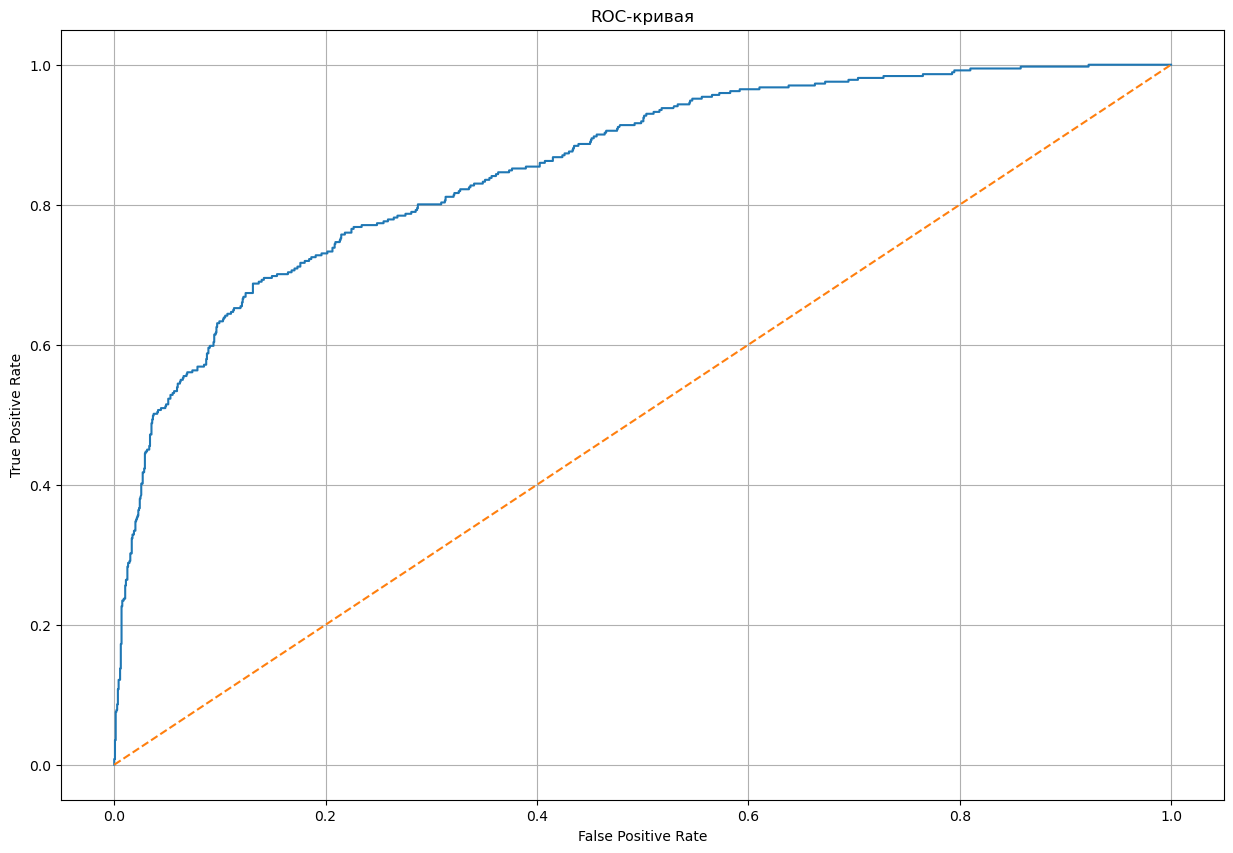

Площадь под ROC - кривой составляет 0.8547778514095099 единиц


In [30]:
probabilities = model_test.predict_proba(features_test)
probabilities_ones = probabilities[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_ones)
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid()

plt.show()
auc_roc = roc_auc_score(target_test, probabilities_ones)
print(f'Площадь под ROC - кривой составляет {auc_roc} единиц')

Исходя из результатов исследования таких метрик, как auc_roc можно сделать вывод, что предсказания нашей модели являются в большей степени "осознаной", а не случайной.

## Вывод

**В результате данной работы нами были проделаны следующие этапы:**
- Подготовка данных
- Исследование задачи
- Борьба с дисбалансом
- Тестирование модели

**В ходе подготовки данных.**

Во-первых мы обработали пропуски, поскольку доля пропусков была равна всего 9 процентам, то мы убрали все строки в котрых были пропущены значения, поскольку не могли полностью определить природу появления пропусков, а так же посчитали не рациональным их заполнение.

Во-вторых с помощью принципа OHE мы обработали столбец в котором в строковом варианте содержались наименование гендера клиента банка. Так же учли ловушку dummy признаков и обработали ее добавив в качестве аргумента "drop_first=True". Так же убрали личный индификатор клиента и его фамилию поскольку эти данные никак не влияют на то уйдет клиент из банка или же нет.

В-третьих обработали данные с помощью принципа OrdinalEncoder. А именно столбце с геолокацией клиента, поскольку данные о местоположении в исходном датасете были записаны с помощью букв. 

Финальным этапом подготовки было маштабирование наших признаков. Так как такие столбцы как счет в банке и количество используемых продуктов банка можно считать равнозначными по степени важности, но порядок чисел описываемых эти столбцы сильно различаются. И чтобы модель считала их равнозначными мы и провели маштабирование признаков.

**Исследование задачи**

На данном этапе мы изучили поведение трех моделей на валидационной выборке, а так же изучили f1 метрику на основе данных без учета дисбаланса. В результате лучше всего себя показала модель "Случайный лес" поскольку только она смогла преодолеть необходимый нам порог значения f1 метрики. 

**Борьба с дисбалансом**

Далее провели исследование модели при различных способов борьбы с дисбалансом в данных и выяснили, что лучше всего нам подходит метод взвешивания классов поскольку модель "Случайного леса" при данном способе борьбы с дисбалансом имеет максимыльный показатель f1 метрики равный 0.95.Остальные модели вели себя одинково при любом методе борьбы с дисбалансом.

**Тестирование модели**

Тестирование было нашим финальным этапом в проекте. Для тестирования нами была выбрана модель "Случайный лес". Поскольку она имела наибольший параметр f1_score равный 0.95. 

В результате тестирования нами был достигнут следующий результат:
- Метрика f1:0.6011396011396012
- Метрика accuracy_score:0.8460692688290269


Так же наша модель была проверена на адекватность и мы убедились, что соотношение классов в предсказании модели было таким же, как и в исходном датасете. 

Была изучена ROC - кривая и вычеслена площадь под ней. В результате мы сделали вывод, что наша модель отличается от случайной модели.
- Площадь под ROC - кривой составляет 0.8547778514095099 единиц
